# Necessary Installations

In [ ]:
pip install newspaper3k

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 7.9 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=357dd066d6c5d57d6dd31b52b31fc0bc15ae0d963f2d7381333140487c5e8918
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=17025f0435d47752c97f5eb224f3f6eafeb63b5081b04fcec03af7e02230559f
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc933

In [ ]:
pip install lxml[html_clean]

# Necessary Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
df1=pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator1.xlsx')
df2=pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator2.xlsx')
df3=pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator3.xlsx')
df4=pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator4.xlsx')

In [4]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(200, 38)
(200, 38)
(200, 38)
(200, 38)


In [5]:
df1.columns

Index(['PostId', 'PostUrl', 'PostEngagement', 'Platform', 'ChannelID',
       'ChannelName', 'ChannelUid', 'ChannelUrl', 'ChannelEngagement',
       'post_body_text', 'post_body_text_pro-republican',
       'post_body_text_pro-democrats', 'post_body_text_con-republican',
       'post_body_text_con-democrats',
       'post_body_text_neither republican not democrats',
       'post_body_text_not-relevant', 'GoogleAudioText', 'VoskAudioText',
       'EmbeddedContentText', 'published_at', 'post_data', 'post_media_urls',
       'LikesCount', 'SharesCount', 'CommentsCount', 'ViewsCount',
       'post_media_file', 'embedded_post_text', 'search_data',
       'team_c2_extracted_url', 'extracted_article_content',
       'extracted_article_content_pro-republican',
       'extracted_article_content_pro-democrats',
       'extracted_article_content_con-republican',
       'extracted_article_content_con-democrats',
       'extracted_article_content_neither republican not democrats',
       'extracted

In [6]:
annotator1 = pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator1.xlsx')
annotator2 = pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator2.xlsx')
annotator3 = pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator3.xlsx')
annotator4 = pd.read_excel('/content/drive/MyDrive/swati_team_c2/Annotator4.xlsx')
postid_summary = pd.read_excel('/content/drive/MyDrive/swati_team_c2/postid_file_summary.xlsx')
annotator_files = {
    'annotator_1.xlsx': annotator1,
    'annotator_2.xlsx': annotator2,
    'annotator_3.xlsx': annotator3,
    'annotator_4.xlsx': annotator4,
}
postid_summary['PostId'] = postid_summary['PostId'].astype(str)
for key in annotator_files:
    annotator_files[key]['PostId'] = annotator_files[key]['PostId'].astype(str)
annotated_columns = [
    'post_body_text_pro-republican', 'post_body_text_pro-democrats',
    'post_body_text_con-republican', 'post_body_text_con-democrats',
    'post_body_text_neither republican not democrats', 'post_body_text_not-relevant',
    'extracted_article_content_pro-republican', 'extracted_article_content_pro-democrats',
    'extracted_article_content_con-republican', 'extracted_article_content_con-democrats',
    'extracted_article_content_neither republican not democrats', 'extracted_article_content_not-relevant'
]

def calculate_agreement(post_id, annotator_files, annotators):
    data = []
    for annotator in annotators:
        file_name = annotator.strip()
        if file_name in annotator_files:
            file_data = annotator_files[file_name]
            row = file_data[file_data['PostId'] == post_id]
            if not row.empty:
                # Process only annotated columns, converting 'yes' to 1 and others to 0
                processed_row = row[annotated_columns].iloc[0].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
                data.append(processed_row.values)
    if len(data) < 2:
        return None, None  # Agreement cannot be calculated for less than two annotators

    # Calculate overall agreement
    data_df = pd.DataFrame(data, columns=annotated_columns)
    overall_agreement = (data_df.nunique() == 1).mean()  # Proportion of complete agreement

    # Calculate agreement per attribute
    per_attribute_agreement = (data_df.nunique() == 1).tolist()
    return overall_agreement, per_attribute_agreement

# Process postid_summary to calculate inter-annotator agreement
agreement_results = []
attribute_agreements = {col: [] for col in annotated_columns}  # Store agreement per attribute

for _, row in postid_summary.iterrows():
    post_id = row['PostId']
    annotators = row['File'].split(',')
    if len(annotators) == 2:  # Only consider PostIds with two annotators
        overall_agreement, per_attribute_agreement = calculate_agreement(post_id, annotator_files, annotators)
        if overall_agreement is not None:
            agreement_results.append({'PostId': post_id, 'Overall Agreement': overall_agreement, 'Annotators': ', '.join(annotators)})
            for col, agreement in zip(annotated_columns, per_attribute_agreement):
                attribute_agreements[col].append(agreement)

attribute_stats = {col: {'Mean Agreement': sum(vals) / len(vals) if vals else 0, 'Total Evaluated': len(vals)} for col, vals in attribute_agreements.items()}
agreement_df = pd.DataFrame(agreement_results)
attribute_stats_df = pd.DataFrame(attribute_stats).T
total_evaluated = len(agreement_df)
mean_overall_agreement = agreement_df['Overall Agreement'].mean()
print(f"Total PostIds Evaluated: {total_evaluated}")
print(f"Mean Overall Agreement: {mean_overall_agreement:.2f}")
print("Attribute-Level Summary:")
attribute_stats_df

Total PostIds Evaluated: 100
Mean Overall Agreement: 0.80
Attribute-Level Summary:


,Mean Agreement,Total Evaluated
post_body_text_pro-republican,0.83,100.0
post_body_text_pro-democrats,0.80,100.0
post_body_text_con-republican,0.85,100.0
post_body_text_con-democrats,0.89,100.0
post_body_text_neither republican not democrats,0.67,100.0
post_body_text_not-relevant,0.85,100.0
extracted_article_content_pro-republican,0.76,100.0
extracted_article_content_pro-democrats,0.82,100.0
extracted_article_content_con-republican,0.75,100.0
extracted_article_content_con-democrats,0.84,100.0


In [7]:
attribute_stats_df.to_csv('/content/drive/MyDrive/swati_team_c2/attribute_stats.csv',index=False)

In [8]:
agreement_df.to_csv('/content/drive/MyDrive/swati_team_c2/inter_annotator_agreement.csv',index=False)

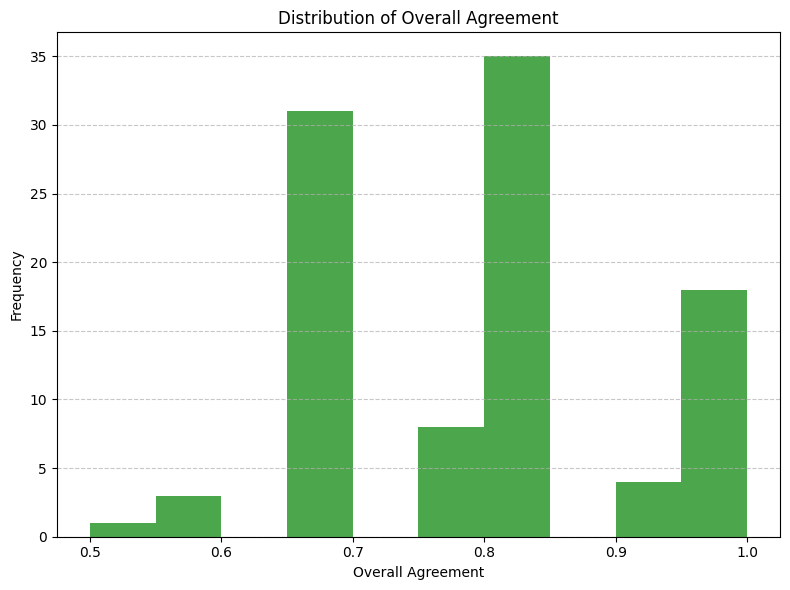

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(agreement_df['Overall Agreement'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of Overall Agreement')
plt.xlabel('Overall Agreement')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

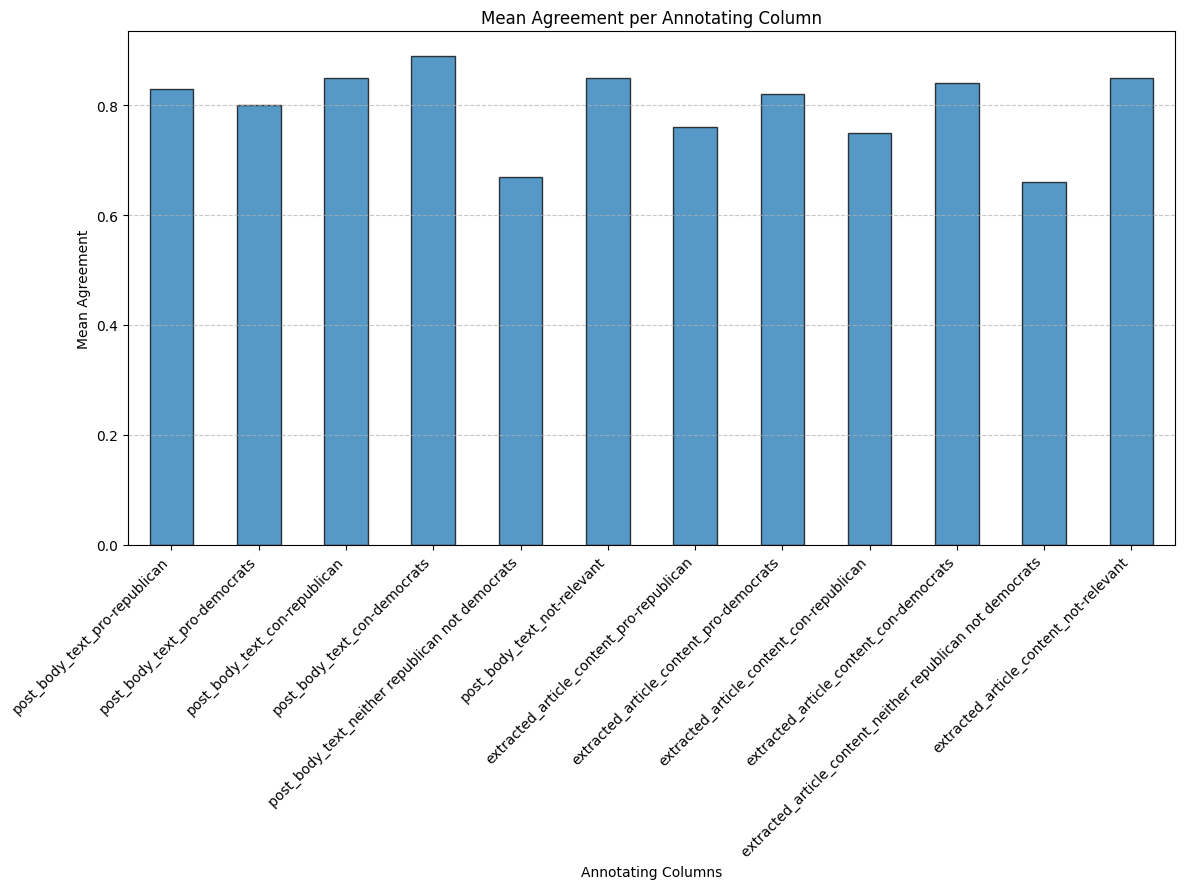

In [10]:
plt.figure(figsize=(12, 9))
attribute_stats_df['Mean Agreement'].plot(kind='bar', alpha=0.75, edgecolor='k')
plt.title('Mean Agreement per Annotating Column')
plt.ylabel('Mean Agreement')
plt.xlabel('Annotating Columns')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
merged_data = []
for _, row in postid_summary.iterrows():
    post_id = row['PostId']
    annotators = row['File'].split(',')  # List of annotators for this PostId

    # If there's only one annotator, add the unique case directly
    if len(annotators) == 1:
        annotator_file = annotator_files.get(annotators[0].strip())
        if annotator_file is not None:
            single_data = annotator_file[annotator_file['PostId'] == post_id].copy()
            if not single_data.empty:
                # Process annotated columns
                single_data.loc[:, annotated_columns] = single_data[annotated_columns].apply(
                    lambda col: col.map(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
                )
                merged_data.append(single_data.iloc[0])  # Add the first row as it's unique

    # If there are two or more annotators, check agreement
    elif len(annotators) > 1:
        overall_agreement, per_attribute_agreement = calculate_agreement(post_id, annotator_files, annotators)

        # If there's full agreement across all annotated columns, add the row
        if overall_agreement == 1:
            # Retrieve data for the first annotator (assumes all annotators agreed)
            annotator_file = annotator_files.get(annotators[0].strip())
            if annotator_file is not None:
                agreed_data = annotator_file[annotator_file['PostId'] == post_id].copy()
                if not agreed_data.empty:
                    # Process annotated columns
                    agreed_data.loc[:, annotated_columns] = agreed_data[annotated_columns].apply(
                        lambda col: col.map(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
                    )
                    merged_data.append(agreed_data.iloc[0])

merged_df = pd.DataFrame(merged_data)
merged_df.reset_index(drop=True, inplace=True)
merged_df.to_csv('/content/drive/MyDrive/swati_team_c2/merged_annotated_data_binary.csv', index=False)
print(f"Merged data saved with {len(merged_df)} entries after filtering disagreements.")

Merged data saved with 618 entries after filtering disagreements.


# Training RoBERTa

In [18]:
df = pd.read_csv('/content/drive/MyDrive/swati_team_c2/political_tweets_partial.csv')

In [13]:
len(df['PostId'].unique())

19210

In [16]:
df.shape

(19210, 26)

In [14]:
df['extraction_method'].value_counts(dropna=False)

,count
extraction_method,
newspaper3k,8168
NaN,8059
BeautifulSoup,2416
Failed,567


In [19]:
filtered_df = df[df['extraction_method'].isin(['newspaper3k', 'BeautifulSoup'])]
filtered_df.to_csv('/content/drive/MyDrive/swati_team_c2/filtered_political_tweets.csv', index=False)

In [20]:
filtered_df.shape

(10584, 26)

In [10]:
filtered_df.columns

Index(['PostId', 'PostUrl', 'PostEngagement', 'Platform', 'ChannelID',
       'ChannelName', 'ChannelUid', 'ChannelUrl', 'ChannelEngagement',
       'post_body_text', 'GoogleAudioText', 'VoskAudioText',
       'EmbeddedContentText', 'published_at', 'post_data', 'post_media_urls',
       'LikesCount', 'SharesCount', 'CommentsCount', 'ViewsCount',
       'post_media_file', 'embedded_post_text', 'search_data',
       'team_c2_extracted_url', 'extracted_article_content',
       'extraction_method'],
      dtype='object')

# Visualizations

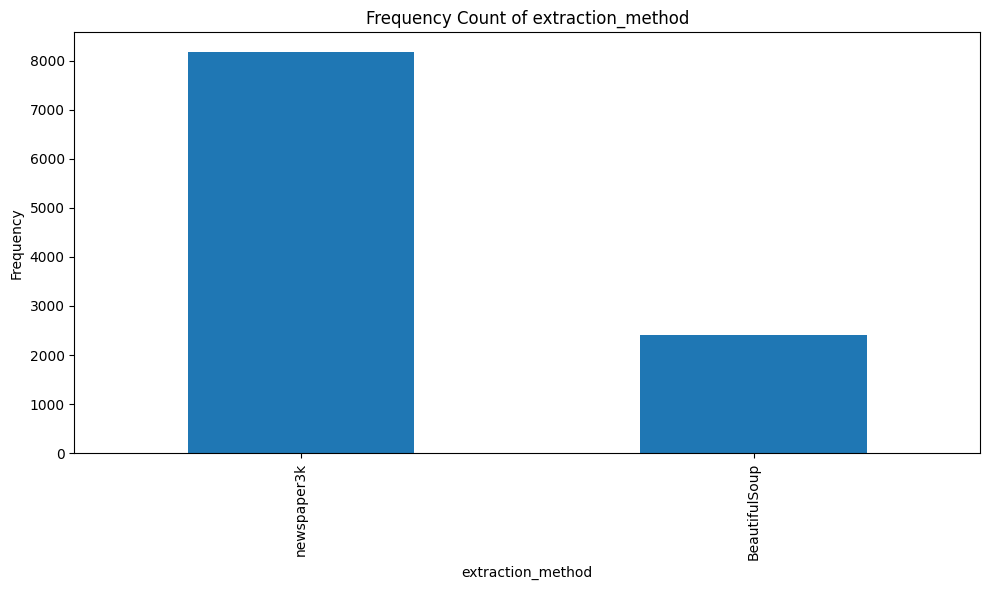

In [16]:
channel_counts = filtered_df['extraction_method'].value_counts()
plt.figure(figsize=(10, 6))
channel_counts.plot(kind='bar')
plt.title('Frequency Count of extraction_method')
plt.xlabel('extraction_method')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

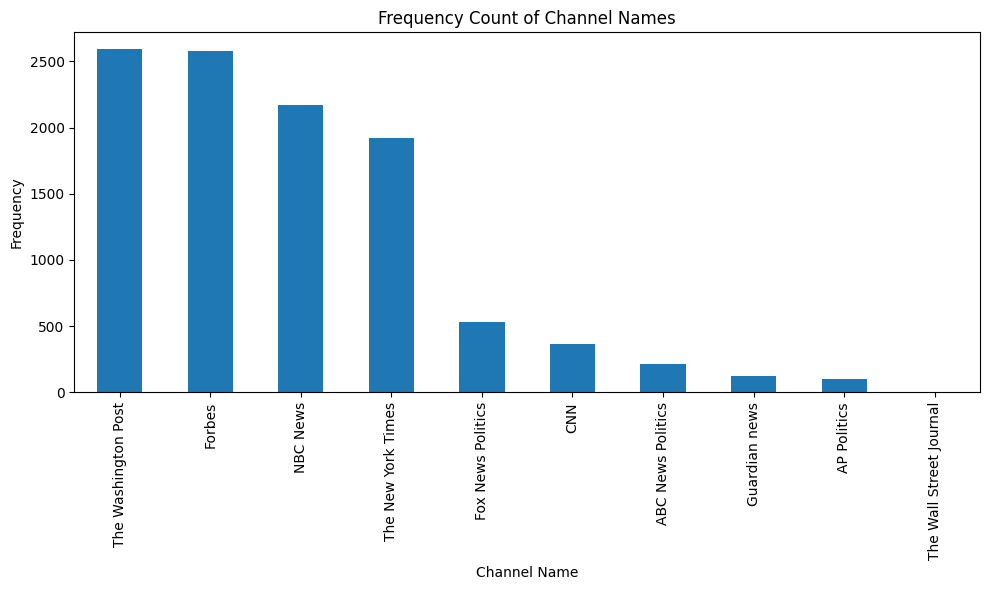

In [17]:
channel_counts = filtered_df['ChannelName'].value_counts()
plt.figure(figsize=(10, 6))
channel_counts.plot(kind='bar')
plt.title('Frequency Count of Channel Names')
plt.xlabel('Channel Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# RoBERTa Training

In [2]:
annotated_data_path = '/content/drive/MyDrive/swati_team_c2/merged_annotated_data_binary.csv'
del_data_path = '/content/drive/MyDrive/swati_team_c2/filtered_political_tweets.csv'
annotated_df = pd.read_csv(annotated_data_path)
del_df = pd.read_csv(del_data_path)
post_body_columns = [
    'post_body_text_pro-republican', 'post_body_text_pro-democrats',
    'post_body_text_con-republican', 'post_body_text_con-democrats',
    'post_body_text_neither republican not democrats', 'post_body_text_not-relevant'
]
extracted_article_columns = [
    'extracted_article_content_pro-republican', 'extracted_article_content_pro-democrats',
    'extracted_article_content_con-republican', 'extracted_article_content_con-democrats',
    'extracted_article_content_neither republican not democrats', 'extracted_article_content_not-relevant'
]

# Dataset class for RoBERTa
class AnnotatedDataset(Dataset):
    def __init__(self, dataframe, tokenizer, text_column, label_columns, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.label_columns = label_columns
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row[self.text_column]
        labels = row[self.label_columns].values.astype(float)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(labels, dtype=torch.float),
        }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
post_body_train_df, post_body_eval_df = train_test_split(annotated_df, test_size=0.2, random_state=42)
article_train_df, article_eval_df = train_test_split(annotated_df, test_size=0.2, random_state=42)
post_body_train_dataset = AnnotatedDataset(
    dataframe=post_body_train_df,
    tokenizer=tokenizer,
    text_column="post_body_text",
    label_columns=post_body_columns,
)
post_body_eval_dataset = AnnotatedDataset(
    dataframe=post_body_eval_df,
    tokenizer=tokenizer,
    text_column="post_body_text",
    label_columns=post_body_columns,
)
post_body_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(post_body_columns)
)
post_body_model.to(device)
post_body_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/swati_team_c2/results/post_body",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/swati_team_c2/logs/post_body",
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
)
post_body_trainer = Trainer(
    model=post_body_model,
    args=post_body_training_args,
    train_dataset=post_body_train_dataset,
    eval_dataset=post_body_eval_dataset,
)

post_body_trainer.train()

article_train_dataset = AnnotatedDataset(
    dataframe=article_train_df,
    tokenizer=tokenizer,
    text_column="extracted_article_content",
    label_columns=extracted_article_columns,
)

article_eval_dataset = AnnotatedDataset(
    dataframe=article_eval_df,
    tokenizer=tokenizer,
    text_column="extracted_article_content",
    label_columns=extracted_article_columns,
)

article_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(extracted_article_columns)
)
article_model.to(device)
article_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/swati_team_c2/results/article",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/swati_team_c2/logs/article",
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
)

article_trainer = Trainer(
    model=article_model,
    args=article_training_args,
    train_dataset=article_train_dataset,
    eval_dataset=article_eval_dataset,
)
article_trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: swati-rajwal (swati-rajwal-emory-university). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.507500,0.450185
2,0.442600,0.442589
3,0.447400,0.432681
4,0.413700,0.404662
5,0.391100,0.388734
6,0.348600,0.380286
7,0.329000,0.377412
8,0.294900,0.375991
9,0.300500,0.376070
10,0.280600,0.375421


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.489800,0.455050
2,0.454500,0.427351
3,0.422000,0.381887
4,0.382100,0.358254
5,0.346600,0.345103
6,0.341600,0.337638
7,0.320800,0.350024
8,0.292100,0.326412
9,0.285700,0.328532
10,0.277500,0.326813


TrainOutput(global_step=465, training_loss=0.33002374915666477, metrics={'train_runtime': 303.1375, 'train_samples_per_second': 24.444, 'train_steps_per_second': 1.534, 'total_flos': 1949722940805120.0, 'train_loss': 0.33002374915666477, 'epoch': 15.0})

In [3]:
class DelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, text_column, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row[self.text_column]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

# Predict for post_body_text
post_body_del_dataset = DelDataset(
    dataframe=del_df,
    tokenizer=tokenizer,
    text_column="post_body_text",
)
post_body_loader = DataLoader(post_body_del_dataset, batch_size=8)
post_body_model.eval()
post_body_predictions = []

for batch in post_body_loader:
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = post_body_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        binary_predictions = (torch.sigmoid(logits).cpu().numpy() > 0.5).astype(int)
        post_body_predictions.extend(binary_predictions)

# Predict for extracted_article_content
article_del_dataset = DelDataset(
    dataframe=del_df,
    tokenizer=tokenizer,
    text_column="extracted_article_content",
)
article_loader = DataLoader(article_del_dataset, batch_size=8)
article_model.eval()
article_predictions = []

for batch in article_loader:
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = article_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        binary_predictions = (torch.sigmoid(logits).cpu().numpy() > 0.5).astype(int)
        article_predictions.extend(binary_predictions)

post_body_predictions_df = pd.DataFrame(post_body_predictions, columns=post_body_columns)
article_predictions_df = pd.DataFrame(article_predictions, columns=extracted_article_columns)
predictions_df = pd.concat([del_df, post_body_predictions_df, article_predictions_df], axis=1)
predictions_df.to_csv("/content/drive/MyDrive/swati_team_c2/roberta_predictions.csv", index=False)
print("Predictions saved to /content/drive/MyDrive/swati_team_c2/")

Predictions saved to /content/drive/MyDrive/swati_team_c2/


In [4]:
gold_standard_path = '/content/drive/MyDrive/swati_team_c2/merged_annotated_data_binary.csv'
predictions_path = '/content/drive/MyDrive/swati_team_c2/roberta_predictions.csv'
gold_df = pd.read_csv(gold_standard_path)
predictions_df = pd.read_csv(predictions_path)
if 'PostId' not in gold_df.columns or 'PostId' not in predictions_df.columns:
    raise ValueError("Both gold standard and predictions must have a 'PostId' column for alignment.")
annotated_columns = [
    'post_body_text_pro-republican', 'post_body_text_pro-democrats',
    'post_body_text_con-republican', 'post_body_text_con-democrats',
    'post_body_text_neither republican not democrats', 'post_body_text_not-relevant',
    'extracted_article_content_pro-republican', 'extracted_article_content_pro-democrats',
    'extracted_article_content_con-republican', 'extracted_article_content_con-democrats',
    'extracted_article_content_neither republican not democrats', 'extracted_article_content_not-relevant'
]
aligned_predictions = predictions_df[predictions_df['PostId'].isin(gold_df['PostId'])]
aligned_gold = gold_df[gold_df['PostId'].isin(aligned_predictions['PostId'])]
aligned_predictions = aligned_predictions.sort_values(by='PostId').reset_index(drop=True)
aligned_gold = aligned_gold.sort_values(by='PostId').reset_index(drop=True)
assert all(aligned_predictions['PostId'] == aligned_gold['PostId']), "Mismatch in PostId alignment."
aligned_predictions = aligned_predictions[annotated_columns]
aligned_gold = aligned_gold[annotated_columns]
print(f"shape of aligned_gold: {aligned_gold.shape}")
print(f"shape of aligned_predictions: {aligned_predictions.shape}")

metrics = {}
for column in annotated_columns:
    gold_labels = aligned_gold[column].astype(int)
    predicted_labels = aligned_predictions[column].astype(int)
    report = classification_report(
        gold_labels,
        predicted_labels,
        output_dict=True,
        zero_division=0
    )
    accuracy = accuracy_score(gold_labels, predicted_labels)
    metrics[column] = {
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1-score": report["1"]["f1-score"],
        "accuracy": accuracy
    }
metrics_df = pd.DataFrame(metrics).T
metrics_df.to_csv("/content/drive/MyDrive/swati_team_c2/roberta_metrics.csv", index=True)
print("Metrics saved to roberta_metrics.csv.")
metrics_df

shape of aligned_gold: (618, 12)
shape of aligned_predictions: (618, 12)
Metrics saved to roberta_metrics.csv.


,precision,recall,f1-score,accuracy
post_body_text_pro-republican,0.761905,0.219178,0.340426,0.899676
post_body_text_pro-democrats,0.966667,0.237705,0.381579,0.847896
post_body_text_con-republican,0.851351,0.926471,0.887324,0.948220
post_body_text_con-democrats,0.829268,0.739130,0.781609,0.969256
post_body_text_neither republican not democrats,0.834906,0.834906,0.834906,0.886731
post_body_text_not-relevant,0.952381,0.769231,0.851064,0.966019
extracted_article_content_pro-republican,1.000000,0.014925,0.029412,0.893204
extracted_article_content_pro-democrats,0.829545,0.584000,0.685446,0.891586
extracted_article_content_con-republican,0.882682,0.887640,0.885154,0.933657
extracted_article_content_con-democrats,0.906977,0.650000,0.757282,0.959547


In [5]:
class_distribution = gold_df[annotated_columns].apply(pd.Series.value_counts).T
print("Class Distribution in Gold Standard:")
class_distribution

Class Distribution in Gold Standard:


,0,1
post_body_text_pro-republican,545,73
post_body_text_pro-democrats,496,122
post_body_text_con-republican,482,136
post_body_text_con-democrats,572,46
post_body_text_neither republican not democrats,406,212
post_body_text_not-relevant,540,78
extracted_article_content_pro-republican,551,67
extracted_article_content_pro-democrats,493,125
extracted_article_content_con-republican,440,178
extracted_article_content_con-democrats,558,60
